# Text Summarization & Visualization

## Setup
To prepare your environment, you need to install some packages.

### Install the necessary packages

You need the latest versions of these packages:<br>

In [1]:
!pip install gensim

Requirement not upgraded as not directly required: gensim in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: scipy>=0.18.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from gensim)
Requirement not upgraded as not directly required: numpy>=1.11.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from gensim)
Requirement not upgraded as not directly required: smart-open>=1.2.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from gensim)
Requirement not upgraded as not directly required: six>=1.5.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from gensim)
Requirement not upgraded as not directly required: boto3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from smart-open>=1.2.1->gensim)
Requirement not upgraded as not directly required: boto>=2.32 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from smart-open>=1.2.1->gensim)
Requirement not upgr

In [2]:
!pip install watson-developer-cloud==1.5

Requirement not upgraded as not directly required: watson-developer-cloud==1.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: Twisted>=13.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud==1.5)
Requirement not upgraded as not directly required: service-identity>=17.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud==1.5)
Requirement not upgraded as not directly required: python-dateutil>=2.5.3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud==1.5)
Requirement not upgraded as not directly required: pyOpenSSL>=16.2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud==1.5)
Requirement not upgraded as not directly required: requests<3.0,>=2.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-developer-cloud==1.5)
Requirement not upgraded as no

In [3]:
!pip install pyldavis

Requirement not upgraded as not directly required: pyldavis in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: joblib>=0.8.4 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required: wheel>=0.23.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required: numpy>=1.9.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required: pytest in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required: future in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required: scipy>=0.18.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pyldavis)
Requirement not upgraded as not directly required

In [4]:
!pip install wordcloud

Requirement not upgraded as not directly required: wordcloud in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: pillow in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from wordcloud)
Requirement not upgraded as not directly required: numpy>=1.6.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from wordcloud)
Requirement not upgraded as not directly required: olefile in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pillow->wordcloud)


In [5]:
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
import watson_developer_cloud
import ibm_boto3
from botocore.client import Config
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import urllib
from bs4 import BeautifulSoup
import requests
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/dsxuser/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /home/dsxuser/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading p

True

## Read the Data
Click on Insert to code and then select Insert Credentials as credentials_1

### Functions to extract files from Cloud Object Storage

In [7]:
cos = ibm_boto3.client('s3',
                    ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                    ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                    ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                    config=Config(signature_version='oauth'),
                    endpoint_url=credentials_1['ENDPOINT'])

def get_file(filename):
    '''Retrieve file from Cloud Object Storage'''
    fileobject = cos.get_object(Bucket=credentials_1['BUCKET'], Key=filename)['Body']
    return fileobject

def load_string(fileobject):
    '''Load the file contents into a Python string'''
    text = fileobject.read()
    return text

### Read the file

In [8]:
text=str(load_string(get_file("Mission_Impossible_6_Review.txt")))

### Helper functions to extract summary and keywords

In [9]:
def get_summary(text, pct):
    summary = summarize(text,ratio=pct,split=True)
    return summary

def get_keywords(text):
    res = keywords(text, ratio=0.1, words=None, split=False, scores=False, pos_filter=('NN', 'JJ'), lemmatize=False, deacc=False)
    res = res.split('\n')
    return res

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def extract_title_text(url):
    page = urllib.request.urlopen(url).read().decode('utf8')
    soup = BeautifulSoup(page,'lxml')
    text = ' '.join(map(lambda p: p.text, soup.find_all('p')))
    return soup.title.text, text

In [10]:
print('Printing Summary')
print('--------------------------')
print(get_summary(text, 0.3))
print ('-------------------------')
print('Printing Keywords')
print('--------------------------')
print(get_keywords(text))

Printing Summary
--------------------------
['b"Before its release, Mission: Impossible Fallout has been known for two things: the fact that it\'s the first direct sequel in the series and THAT injury to Tom Cruise.Let\'s get the injury out of the way first.', "The shot is in the movie and it will make you wince because you know the context, but otherwise you don't really notice any difference as the stunt in question is just the latest in a long line of deathdefying activities featuring Cruise.What makes more of an impact on the sixth movie in the series is its connection to the previous movie, Rogue Nation, with the return of the villainous Solomon Lane (played creepily again by Sean Harris) and his nefarious Syndicate, who are again threatening the world.With the addition of Ethan Hunt's former wife Julia (Michelle Monaghan) from the third movie, Fallout is immediately given more depth than previous outings and the stakes feel higher, with Ethan Hunt (Cruise) haunted by his past mis

### Remove punctuation & special characters

In [11]:
import re
my_new_text = re.sub('[^ a-zA-Z0-9]', '', text)

### Preprocess the text for next steps

In [12]:
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str(my_new_text)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

### Create n grams where n is the number of words

In [13]:
from nltk import ngrams
n = 7
total_grams = []
number_of_grams = ngrams(normalized.split(), n)
for grams in number_of_grams:
    total_grams.append(grams)

In [14]:
print(total_grams[:10])

[('bBefore', 'release', 'Mission', 'Impossible', 'Fallout', 'known', 'two'), ('release', 'Mission', 'Impossible', 'Fallout', 'known', 'two', 'thing'), ('Mission', 'Impossible', 'Fallout', 'known', 'two', 'thing', 'fact'), ('Impossible', 'Fallout', 'known', 'two', 'thing', 'fact', 'first'), ('Fallout', 'known', 'two', 'thing', 'fact', 'first', 'direct'), ('known', 'two', 'thing', 'fact', 'first', 'direct', 'sequel'), ('two', 'thing', 'fact', 'first', 'direct', 'sequel', 'series'), ('thing', 'fact', 'first', 'direct', 'sequel', 'series', 'THAT'), ('fact', 'first', 'direct', 'sequel', 'series', 'THAT', 'injury'), ('first', 'direct', 'sequel', 'series', 'THAT', 'injury', 'Tom')]


### Create the wordcloud visualization on the processed data
To highlight important textual data points & convey crucial information. The more a specific word appears in a source of textual data, the bigger and bolder it appears in the word cloud.

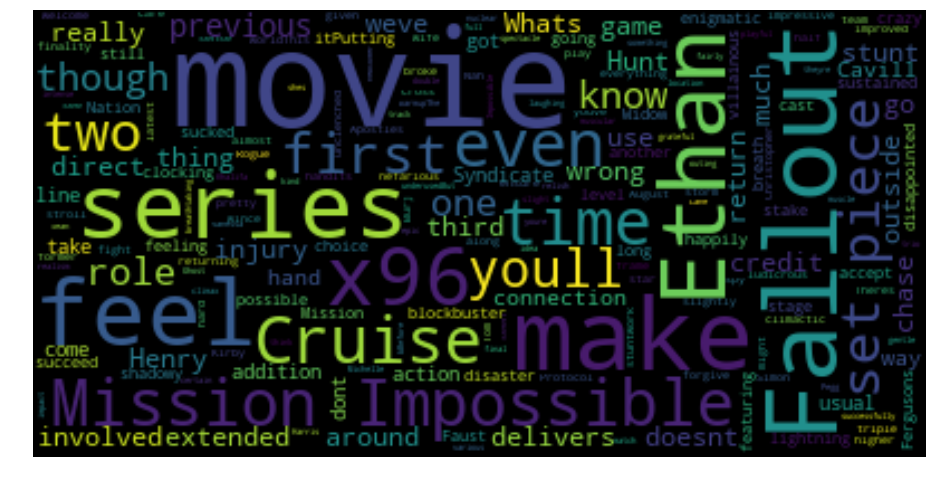

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Analyze the frequency of words in the text. 

In [16]:
count = {}
for w in normalized.split():
    if w in count:
        count[w] += 1
    else:
        count[w] = 1
for word, times in count.items():
    if times > 3:
        print("%s was found %d times" % (word, times))

Mission was found 4 times
Impossible was found 4 times
make was found 6 times
time was found 4 times
x96 was found 4 times
series was found 5 times
feel was found 5 times
Ethan was found 4 times
Cruise was found 4 times
even was found 4 times
movie was found 12 times
get was found 4 times
Fallout was found 6 times


### Create a Dispersion plot
The motivation behind using the Lexical Dispersion Plots was to give us an alternative means of visualising how prevalent  these words are in the text corpus, whether or not there was a clustering pattern that is whether or not a word featured heavily at certain point of the text corpus.

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


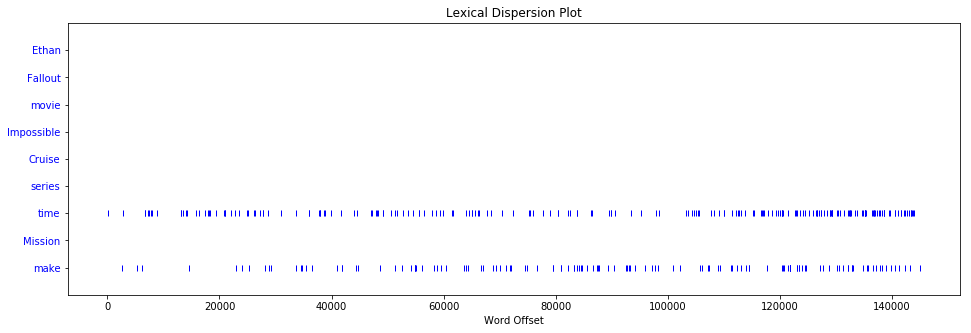

In [17]:
from nltk.book import text4 as content
plt.figure(figsize=(16,5))
topics = ['Ethan', 'Fallout','movie', 'Impossible', 'Cruise', 'series', 'time', 'Mission', 'make']
content.dispersion_plot(topics)

### Start the preprocessing for Topic Modelling

Topic Modelling is an approach for finding topics in large amounts of text. Topic modeling is great for document clustering, information retrieval from unstructured text, and feature selection.
 
Topic Modeling with Latent Dirichlet Allocation technique.

Why Latent Dirichlet Allocation? This technique can create model which can be generalized easily on any new text corpus and help us in identifying the important topics from the corpus. 

Some of the advantages are :

Training documents may come in sequentially, no random access required.

Runs in constant memory w.r.t. the number of documents: size of the training corpus does not affect memory footprint, can process corpora larger than RAM.

Is distributed & makes use of a cluster of machines, if available, to speed up model estimation.

In [18]:
import gensim
from gensim import corpora

tokenized_sents = list(sent_to_words(filtered_sentence))

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]

### Creating the object for LDA model & train the model

In [19]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix by selecting minimum parameters required.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=100)

### Extract two topics with twenty words in each topic

In [20]:
print(ldamodel.print_topics(num_topics=2, num_words=20))

[(0, '0.014*"series" + 0.012*"even" + 0.012*"makes" + 0.009*"youll" + 0.009*"previous" + 0.009*"first" + 0.009*"role" + 0.009*"two" + 0.009*"set" + 0.007*"whats" + 0.007*"wrong" + 0.007*"weve" + 0.007*"dont" + 0.007*"involved" + 0.007*"pieces" + 0.007*"third" + 0.007*"its" + 0.007*"usual" + 0.007*"way" + 0.007*"games"'), (1, '0.024*"movie" + 0.016*"fallout" + 0.014*"mission" + 0.014*"impossible" + 0.011*"cruise" + 0.011*"theres" + 0.011*"get" + 0.011*"ethan" + 0.011*"feel" + 0.009*"like" + 0.009*"movies" + 0.009*"one" + 0.009*"though" + 0.006*"the" + 0.006*"times" + 0.006*"really" + 0.006*"addition" + 0.006*"direct" + 0.006*"make" + 0.006*"doesnt"')]


#### Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 

In [21]:
'''Compute Perplexity'''

# a measure of how good the model is. lower the better.

print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.64337821887

Coherence Score:  0.862199653177


#### Coherence score is 'higher the better' metric and given the score of 0.86 we can be assured that we have selected the right number of topics for this corpus.

In [22]:
'''Visualize the topics'''
# pyLDAvis tool to visualize the fit of our LDA model across topics and their top words. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
1      51.304699        1       1  0.084186  0.0
0      48.695301        1       2 -0.084186  0.0, topic_info=     Category      Freq          Term     Total  loglift  logprob
term                                                             
274   Default  5.000000         movie  5.000000  30.0000  30.0000
62    Default  3.000000       fallout  3.000000  29.0000  29.0000
195   Default  3.000000        series  3.000000  28.0000  28.0000
99    Default  3.000000    impossible  3.000000  27.0000  27.0000
326   Default  3.000000       mission  3.000000  26.0000  26.0000
273   Default  2.000000          even  2.000000  25.0000  25.0000
10    Default  2.000000         makes  2.000000  24.0000  24.0000
135   Default  2.000000        theres  2.000000  23.0000  23.0000
331   Default  2.000000           get  2.000000  22.0000  22.0000
225   Default  2.000000          feel  2.000000  21.0000  21.0000
172   Default  2.000000        cruise  2.000000  20.0000  20.0000
156   Default  2.000000         ethan  2.000000  19.0000  19.0000
159   Default  2.000000         youll  2.000000  18.0000  18.0000
268   Default  2.000000          role  2.000000  17.0000  17.0000
11    Default  2.000000           two  2.000000  16.0000  16.0000
65    Default  2.000000         first  2.000000  15.0000  15.0000
297   Default  2.000000      previous  2.000000  14.0000  14.0000
16    Default  2.000000           set  2.000000  13.0000  13.0000
45    Default  2.000000        movies  2.000000  12.0000  12.0000
109   Default  2.000000          like  2.000000  11.0000  11.0000
255   Default  2.000000        though  2.000000  10.0000  10.0000
262   Default  2.000000           one  2.000000   9.0000   9.0000
147   Default  1.000000         henry  1.000000   8.0000   8.0000
37    Default  1.000000         whats  1.000000   7.0000   7.0000
239   Default  1.000000           way  1.000000   6.0000   6.0000
58    Default  1.000000          weve  1.000000   5.0000   5.0000
226   Default  1.000000         games  1.000000   4.0000   4.0000
257   Default  1.000000           its  1.000000   3.0000   3.0000
247   Default  1.000000          dont  1.000000   2.0000   2.0000
280   Default  1.000000         usual  1.000000   1.0000   1.0000
...       ...       ...           ...       ...      ...      ...
141    Topic2  0.839648  blockbusters  1.133865   0.4192  -5.5465
20     Topic2  0.839648      protocol  1.133865   0.4192  -5.5465
123    Topic2  0.839648     something  1.133865   0.4192  -5.5465
52     Topic2  0.839648       handits  1.133865   0.4192  -5.5465
234    Topic2  0.839648        ethans  1.133865   0.4192  -5.5465
107    Topic2  0.839648         hands  1.133865   0.4192  -5.5465
76     Topic2  0.839648          pack  1.133865   0.4192  -5.5465
214    Topic2  0.839648         there  1.133865   0.4192  -5.5465
188    Topic2  0.839648          foot  1.133865   0.4192  -5.5465
143    Topic2  0.839648       intense  1.133865   0.4192  -5.5465
198    Topic2  0.839648        double  1.133865   0.4192  -5.5465
113    Topic2  0.839648         faust  1.133865   0.4192  -5.5465
196    Topic2  0.839648     newcomers  1.133865   0.4192  -5.5465
290    Topic2  0.839648         would  1.133865   0.4192  -5.5465
210    Topic2  0.839648         count  1.133865   0.4192  -5.5465
114    Topic2  0.839648      mistakes  1.133865   0.4192  -5.5465
70     Topic2  0.839648        theyre  1.133865   0.4192  -5.5465
126    Topic2  0.839648     fergusons  1.133865   0.4192  -5.5465
166    Topic2  0.839648          take  1.133865   0.4192  -5.5465
292    Topic2  0.839648      creepily  1.133865   0.4192  -5.5465
256    Topic2  0.839648       contain  1.133865   0.4192  -5.5465
95     Topic2  0.839648     climactic  1.133865   0.4192  -5.5465
316    Topic2  0.839648           yet  1.133865   0.4192  -5.5465
129    Topic2  0.839648        higher  1.133865   0.4192  -5.5465

#### We can observe that our LDA model has captured the prominent keywords under two topics in the text corpus which will give us a good understanding of what the text corpus is about. We can do further analysis by using this information to generate recommendations & classify the text for user profiling or push notifications. 

## In the next section, we will see how we can summarize and visualize news article!

In [23]:
'''Extract the first article of the news feed'''

url = urllib.request.urlopen('http://feeds.bbci.co.uk/news/rss.xml').read()
feed = BeautifulSoup(url.decode('utf8'),'lxml')
urls_to_summarize = list(map(lambda p: p.text, feed.find_all('guid')))
for article_url in urls_to_summarize[:1]:
    title, text = extract_title_text(article_url)
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing title & text')
    print('-----------------------')
    print (title, text)
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing title & summary')
    print('--------------------------')
    print (title)
    for s in get_summary(text, 0.2):
        print((s))
    print ('-------------------------------------------------------------------------------------------------------------------')
    print('Printing Keywords')
    print('--------------------------')
    for i in get_keywords(text):
        print((i))

-------------------------------------------------------------------------------------------------------------------
Printing title & text
-----------------------
Brexit: UK to consider longer transition period - BBC News  Share this with Email Facebook Messenger Messenger Twitter Pinterest WhatsApp LinkedIn Copy this link These are external links and will open in a new window UK government sources say they would consider an extension to the UK's transition out of the EU by a few months, if needed. The move could buy the two sides more time to come up with a solution to the problem of the Irish border. It comes after a summit of EU leaders in Brussels failed to make decisive progress in  reaching an agreement. The UK leaves the EU in March, and the current plan is for the transition period to finish at the end of 2020. Some some Brexit-backing MPs have reacted angrily to the idea of extending this period. It could mean the UK would have to follow EU rules for longer and would be likely 

In [24]:
_title = []
_text = []
_summarized_text = []

for article_url in urls_to_summarize[:1]:
    title, text = extract_title_text(article_url)
    new_text = get_summary(text, 0.3)
    _title.append(title), _text.append(text), _summarized_text.append(new_text)

In [25]:
article_text = _text[0]
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
word_tokens = word_tokenize(str(article_text)) 
filtered_sentence = [w for w in word_tokens if not w in stop_words]
normalized = " ".join(lemma.lemmatize(word) for word in filtered_sentence)

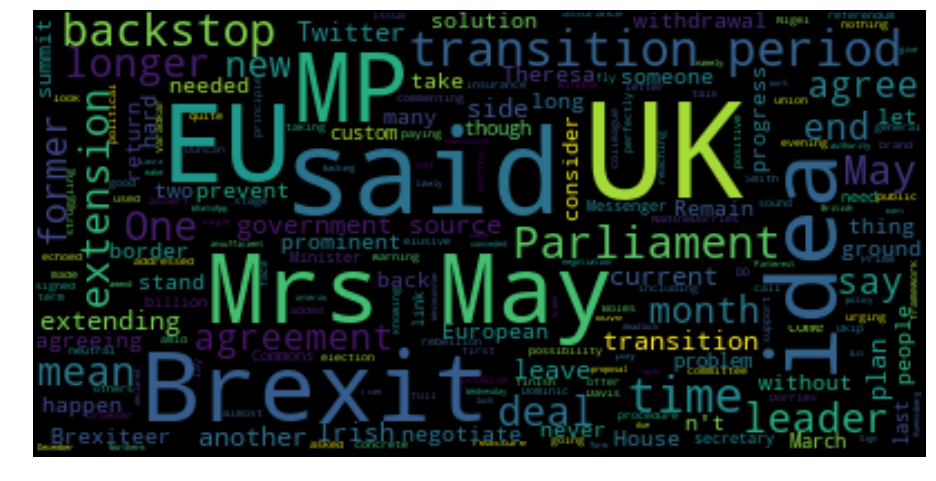

In [26]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=60).generate(normalized)
plt.figure(figsize=(16,12))

'''plot wordcloud in matplotlib'''

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

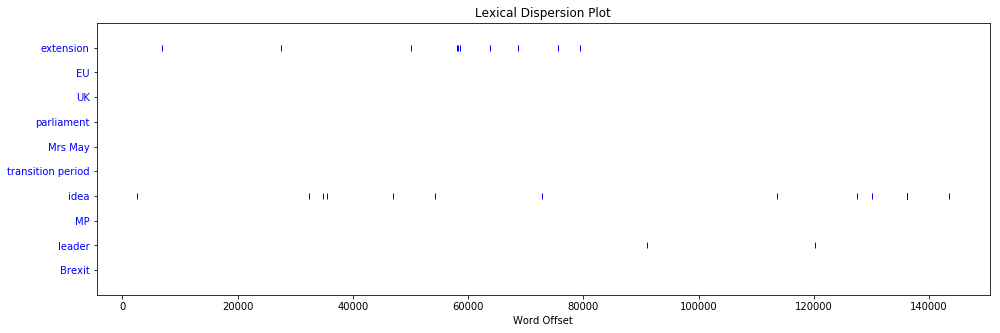

In [27]:
from nltk.book import text4 as content
plt.figure(figsize=(16,5))
topics = ['extension', 'EU','UK', 'parliament', 'Mrs May', 'transition period', 'idea', 'MP', 'leader', 'Brexit']
content.dispersion_plot(topics)

### We can observe that idea is being discussed throughout the article along with references to leader & extension. This will change as per the text corpus. 

In [28]:
tokenized_sents = list(sent_to_words(filtered_sentence))

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_sents)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_sents]

In [29]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=100)

# Print the model output
print(ldamodel.print_topics(num_topics=2, num_words=20))

[(0, '0.031*"would" + 0.022*"said" + 0.015*"the" + 0.015*"mrs" + 0.013*"idea" + 0.013*"parliament" + 0.010*"mean" + 0.010*"extension" + 0.010*"deal" + 0.008*"irish" + 0.008*"agreement" + 0.008*"leave" + 0.008*"another" + 0.008*"sources" + 0.008*"sides" + 0.008*"former" + 0.008*"end" + 0.006*"remain" + 0.006*"long" + 0.006*"mp"'), (1, '0.027*"uk" + 0.023*"may" + 0.021*"transition" + 0.019*"eu" + 0.016*"period" + 0.014*"brexit" + 0.014*"time" + 0.012*"backstop" + 0.012*"it" + 0.010*"mps" + 0.010*"one" + 0.010*"longer" + 0.008*"twitter" + 0.008*"but" + 0.008*"extending" + 0.008*"new" + 0.008*"could" + 0.008*"current" + 0.008*"government" + 0.008*"get"')]


#### Run the below cell only if the model needs to be saved otherwise omit this cell and proceed to next cell

In [ ]:
'''Save the model'''

from gensim.test.utils import datapath
temp_file = datapath("/home/dsxuser/")
ldamodel.save(temp_file)

'''Load the model'''

ldamodel = LdaModel.load(temp_file)

'''Update the model on new and unseen data'''

ldamodel.update(new_data)

In [30]:
'''Compute Perplexity'''

# a measure of how good the model is. Lower the better.
print('\nPerplexity: ', ldamodel.log_perplexity(doc_term_matrix))

'''Compute Coherence Score'''

coherence_model_lda = CoherenceModel(model=ldamodel, texts=tokenized_sents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.46928310279

Coherence Score:  0.861589300918


#### pyLDAvis is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.

In [31]:
'''Visualize the topics'''
# pyLDAvis tool to visualize the fit of our LDA model across topics and their top words. 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x    y
topic                                           
1      50.786434        1       1  0.103881  0.0
0      49.213573        1       2 -0.103881  0.0, topic_info=     Category      Freq        Term     Total  loglift  logprob
term                                                           
189   Default  8.000000       would  8.000000  30.0000  30.0000
195   Default  7.000000          uk  7.000000  29.0000  29.0000
183   Default  6.000000         may  6.000000  28.0000  28.0000
34    Default  6.000000        said  6.000000  27.0000  27.0000
169   Default  6.000000  transition  6.000000  26.0000  26.0000
229   Default  5.000000          eu  5.000000  25.0000  25.0000
129   Default  4.000000      period  4.000000  24.0000  24.0000
276   Default  4.000000         the  4.000000  23.0000  23.0000
148   Default  4.000000         mrs  4.000000  22.0000  22.0000
300   Default  4.000000      brexit  4.000000  21.0000  21.0000
98    Default  4.000000        time  4.000000  20.0000  20.0000
259   Default  3.000000        idea  3.000000  19.0000  19.0000
319   Default  3.000000  parliament  3.000000  18.0000  18.0000
219   Default  3.000000    backstop  3.000000  17.0000  17.0000
77    Default  3.000000          it  3.000000  16.0000  16.0000
133   Default  3.000000        mean  3.000000  15.0000  15.0000
146   Default  3.000000   extension  3.000000  14.0000  14.0000
46    Default  3.000000        deal  3.000000  13.0000  13.0000
275   Default  3.000000         mps  3.000000  12.0000  12.0000
97    Default  3.000000         one  3.000000  11.0000  11.0000
100   Default  3.000000      longer  3.000000  10.0000  10.0000
204   Default  2.000000     another  2.000000   9.0000   9.0000
57    Default  2.000000     sources  2.000000   8.0000   8.0000
33    Default  2.000000   agreement  2.000000   7.0000   7.0000
165   Default  2.000000       leave  2.000000   6.0000   6.0000
190   Default  2.000000       sides  2.000000   5.0000   5.0000
22    Default  2.000000       irish  2.000000   4.0000   4.0000
239   Default  2.000000      former  2.000000   3.0000   3.0000
45    Default  2.000000         end  2.000000   2.0000   2.0000
240   Default  2.000000         but  2.000000   1.0000   1.0000
...       ...       ...         ...       ...      ...      ...
190    Topic2  2.129236       sides  2.445862   0.5704  -4.8342
45     Topic2  2.129236         end  2.445862   0.5704  -4.8342
239    Topic2  2.129236      former  2.445862   0.5704  -4.8342
201    Topic2  1.520365      remain  1.833869   0.5215  -5.1710
4      Topic2  1.520365        long  1.833869   0.5215  -5.1710
192    Topic2  1.517000          mp  1.833845   0.5193  -5.1732
103    Topic2  1.517000    consider  1.833845   0.5193  -5.1732
104    Topic2  1.517000     without  1.833845   0.5193  -5.1732
110    Topic2  1.517000      months  1.833845   0.5193  -5.1732
309    Topic2  1.517000     theresa  1.833845   0.5193  -5.1732
82     Topic2  1.517000      leader  1.833845   0.5193  -5.1732
116    Topic2  1.517000         and  1.833845   0.5193  -5.1732
63     Topic2  1.517000    european  1.833845   0.5193  -5.1732
202    Topic2  1.517000      happen  1.833845   0.5193  -5.1732
238    Topic2  1.517000         let  1.833845   0.5193  -5.1732
289    Topic2  1.517000      ground  1.833845   0.5193  -5.1732
220    Topic2  1.517000        hard  1.833845   0.5193  -5.1732
266    Topic2  1.517000      people  1.833845   0.5193  -5.1732
160    Topic2  1.517000   secretary  1.833845   0.5193  -5.1732
304    Topic2  1.517000      though  1.833845   0.5193  -5.1732
50     Topic2  1.517000         say  1.833845   0.5193  -5.1732
334    Topic2  1.517000     leaders  1.833845   0.5193  -5.1732
290    Topic2  1.517000      summit  1.833845   0.5193  -5.1732
21     Topic2  1.517000   prominent  1.833845   0.5193  -5.1732
38     Topic2  1.517000        back  1.833845   0.5193  -5.1732
226    Topic2  1.517000     customs  1.833845   0

### We have seen how to summarize & visualize a document as well as a news article to get quick information about the data. This methodology can be applied to lot of usecases to extract insights from unstructured data.